In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import db_builder.db_handler as dbh
import logging
from getpass import getpass
from datetime import datetime
from fpdf import FPDF
import usage_time as utp
import seaborn as sns

#plotter = utp.UsageTimePlotter()
db_params = {
    'user': 'postgres',
    'password': getpass('Please enter DB pw'),  # enter your DB password
    'host': 'localhost',  # 'localhost' or IP address
    'port': '5432',  # '5432'
    'database': 'ttdatabase',  #tensionTerminator
}
toolcheck = dbh.DB_Conn(db_params)
toolcheck.connect()
engine = toolcheck.get_engine()

Connected to PostgreSQL, DB: ttdatabase


In [84]:
df = toolcheck.get_data()
df

2023-11-30 10:26:11,777 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-11-30 10:26:11,778 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-30 10:26:11,779 INFO sqlalchemy.engine.Engine select current_schema()
2023-11-30 10:26:11,779 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-30 10:26:11,780 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-11-30 10:26:11,781 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-30 10:26:11,781 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-11-30 10:26:11,782 INFO sqlalchemy.engine.Engine 
            SELECT l.id AS loop_id, l.timestamp, l.session_length, l.location, l.human_labeled, v.file_path, u.name, u.surename, 
            b.bodyside_id, t.tool_id, tt.tool, tt.time_in_use AS tool_time_in_use, bs.side AS bodyside, bs.time_in_use AS bodyside_time_in_use
            FROM loop l
            LEFT JOIN video v ON l.id = v.loop_id AND v.device = 'rgbCam'
            LEFT JOIN users u ON l.user_id = u.id
     

,loop_id,timestamp,session_length,location,human_labeled,file_path,name,surename,bodyside_id,tool_id,tool,tool_time_in_use,bodyside,bodyside_time_in_use
0,1,2023-09-08 19:12:12.778376,116,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Martin,Hofer,2,2,trigger,None,left,None
1,2,2023-09-08 19:15:23.051845,132,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Juergen,Zangerl,2,2,trigger,None,left,None
2,3,2023-09-08 19:20:38.981489,54,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Christina,Greiderer,2,2,trigger,None,left,None
3,4,2023-09-08 19:21:18.026639,98,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Philipp,Egger,2,2,trigger,None,left,None
4,5,2023-09-08 19:23:23.087926,101,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Lukas,Prenner,2,2,trigger,None,left,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,150,2023-10-13 14:27:46.668796,122,MCI,False,D:/BigBlock_01/tt_video_data/videos-2023-10-13...,Pirmin,Aster,69,47,duoballs,00:02:02,middle,00:01:56
388,150,2023-10-13 14:27:46.668796,122,MCI,False,D:/BigBlock_01/tt_video_data/videos-2023-10-13...,Pirmin,Aster,69,48,trigger,00:00:00,middle,00:01:56
389,150,2023-10-13 14:27:46.668796,122,MCI,False,D:/BigBlock_01/tt_video_data/videos-2023-10-13...,Pirmin,Aster,70,1,unknown,None,right,00:00:00
390,150,2023-10-13 14:27:46.668796,122,MCI,False,D:/BigBlock_01/tt_video_data/videos-2023-10-13...,Pirmin,Aster,70,47,duoballs,00:02:02,right,00:00:00


In [85]:
def convert_to_timedelta(x):
    if x is not None:
        return pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second)
    else:
        return None

In [86]:
df['session_length'] = pd.to_timedelta(df['session_length'], unit='s', errors='coerce')
df['tool_time_in_use'] = df['tool_time_in_use'].apply(convert_to_timedelta)
df['bodyside_time_in_use'] = df['bodyside_time_in_use'].apply(convert_to_timedelta)


filtered_tools_rows = df[(df['human_labeled'] == True) & 
                         ((df['tool'] == 'trigger') | 
                          (df['tool'] == 'big duoballs') | 
                          (df['tool'] == 'small duoballs') | 
                          (df['tool'] == 'duoballs'))].index


filtered_bodyside_rows = df[(df['human_labeled'] == True) & 
                            ((df['bodyside'] == 'left') | 
                             (df['bodyside'] == 'middle') | 
                             (df['bodyside'] == 'right'))].index

df.loc[filtered_tools_rows, 'tool_time_in_use'] = df.loc[filtered_tools_rows, 'session_length']
df.loc[filtered_bodyside_rows, 'bodyside_time_in_use'] = df.loc[filtered_bodyside_rows, 'session_length']
df['tool'] = df['tool'].replace(['big duoballs', 'small duoballs'], 'duoballs')

df = df[df['tool_id'] != 1]
df = df[df['bodyside_id'] != 1]
df = df.drop(['tool_id', 'bodyside_id'], axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['session_length_sec'] = df['session_length'].dt.total_seconds()
df['tool_time_in_use_sec'] = df['tool_time_in_use'].dt.total_seconds()
df['bodyside_time_in_use_sec'] = df['bodyside_time_in_use'].dt.total_seconds()
df = df[(df['session_length_sec'] != 0.0) & (df['tool_time_in_use_sec'] != 0.0) & (df['bodyside_time_in_use_sec'] != 0.0)]
df

,loop_id,timestamp,session_length,location,human_labeled,file_path,name,surename,tool,tool_time_in_use,bodyside,bodyside_time_in_use,session_length_sec,tool_time_in_use_sec,bodyside_time_in_use_sec
0,1,2023-09-08 19:12:12.778376,0 days 00:01:56,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Martin,Hofer,trigger,0 days 00:01:56,left,0 days 00:01:56,116.0,116.0,116.0
1,2,2023-09-08 19:15:23.051845,0 days 00:02:12,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Juergen,Zangerl,trigger,0 days 00:02:12,left,0 days 00:02:12,132.0,132.0,132.0
2,3,2023-09-08 19:20:38.981489,0 days 00:00:54,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Christina,Greiderer,trigger,0 days 00:00:54,left,0 days 00:00:54,54.0,54.0,54.0
3,4,2023-09-08 19:21:18.026639,0 days 00:01:38,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Philipp,Egger,trigger,0 days 00:01:38,left,0 days 00:01:38,98.0,98.0,98.0
4,5,2023-09-08 19:23:23.087926,0 days 00:01:41,MCI,True,D:/BigBlock_01/tt_video_data/videos-2023-09-08...,Lukas,Prenner,trigger,0 days 00:01:41,left,0 days 00:01:41,101.0,101.0,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,149,2023-10-13 14:24:40.737588,0 days 00:00:34,MCI,False,D:/BigBlock_01/tt_video_data/videos-2023-10-13...,Pirmin,Aster,trigger,0 days 00:00:35,left,0 days 00:00:23,34.0,35.0,23.0
379,149,2023-10-13 14:24:40.737588,0 days 00:00:34,MCI,False,D:/BigBlock_01/tt_video_data/videos-2023-10-13...,Pirmin,Aster,trigger,0 days 00:00:35,middle,0 days 00:00:03,34.0,35.0,3.0
382,149,2023-10-13 14:24:40.737588,0 days 00:00:34,MCI,False,D:/BigBlock_01/tt_video_data/videos-2023-10-13...,Pirmin,Aster,trigger,0 days 00:00:35,right,0 days 00:00:09,34.0,35.0,9.0
384,150,2023-10-13 14:27:46.668796,0 days 00:02:02,MCI,False,D:/BigBlock_01/tt_video_data/videos-2023-10-13...,Pirmin,Aster,duoballs,0 days 00:02:02,left,0 days 00:00:06,122.0,122.0,6.0


In [87]:
df.columns

Index(['loop_id', 'timestamp', 'session_length', 'location', 'human_labeled',
       'file_path', 'name', 'surename', 'tool', 'tool_time_in_use', 'bodyside',
       'bodyside_time_in_use', 'session_length_sec', 'tool_time_in_use_sec',
       'bodyside_time_in_use_sec'],
      dtype='object')

In [88]:
df.dtypes

loop_id                               int64
timestamp                    datetime64[ns]
session_length              timedelta64[ns]
location                             object
human_labeled                          bool
file_path                            object
name                                 object
surename                             object
tool                                 object
tool_time_in_use            timedelta64[ns]
bodyside                             object
bodyside_time_in_use        timedelta64[ns]
session_length_sec                  float64
tool_time_in_use_sec                float64
bodyside_time_in_use_sec            float64
dtype: object

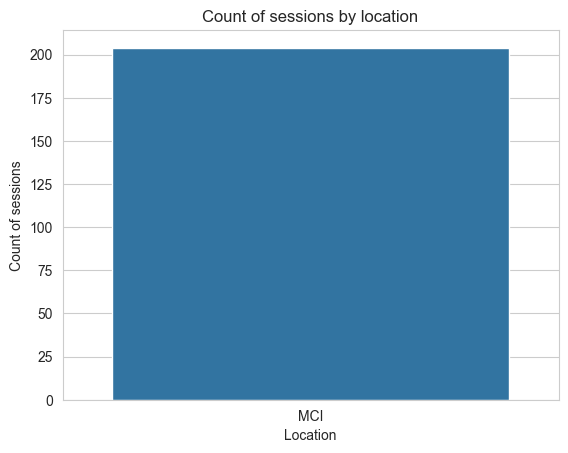

In [89]:
title = 'Count of sessions by location'

date_labels = df['timestamp'].dt.strftime('%Y-%m-%d')

session_count_by_location = df['location'].value_counts()
sns.barplot(x=session_count_by_location.index, y=session_count_by_location.values)
plt.title(title)
plt.xlabel('Location')
plt.ylabel('Count of sessions')
plt.savefig(f"diagrams/{title}.png")

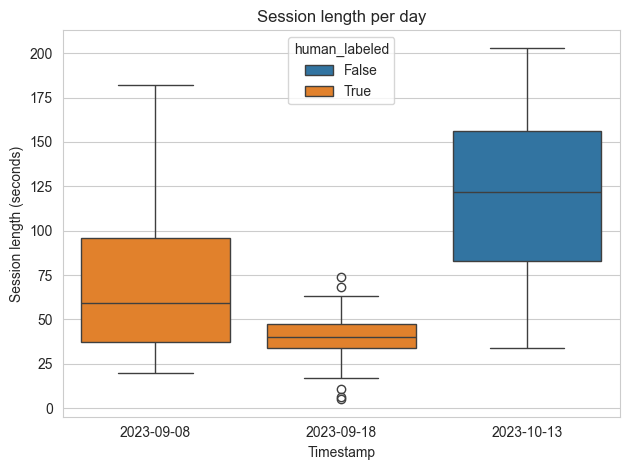

In [90]:
title = 'Session length per day'

date_labels = df['timestamp'].dt.strftime('%Y-%m-%d')
sns.boxplot(x=date_labels, y='session_length_sec', data=df, hue='human_labeled')
plt.title(title)
plt.xlabel('Timestamp')
plt.ylabel('Session length (seconds)')
plt.tight_layout()
plt.savefig(f"diagrams/{title}.png")

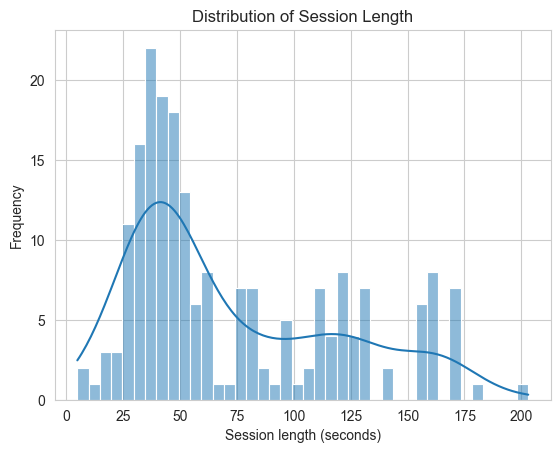

In [91]:
title = 'Distribution of Session Length'

sns.histplot(df['session_length_sec'], bins=40, kde=True)
plt.title(title)
plt.xlabel('Session length (seconds)')
plt.ylabel('Frequency')
plt.savefig(f"diagrams/{title}.png")

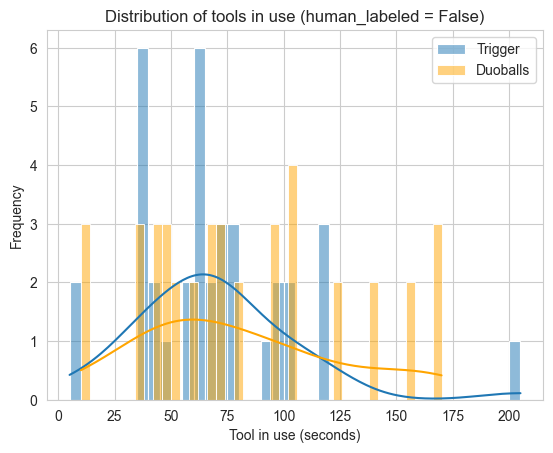

In [92]:
title = 'Distribution of tools in use (human_labeled = False)'

filtered_trigger_df = df[(df['human_labeled'] == False) & (df['tool'] == 'trigger')]
filtered_duoballs_df = df[(df['human_labeled'] == False) & (df['tool'] == 'duoballs')]

sns.histplot(filtered_trigger_df['tool_time_in_use_sec'], bins=40, kde=True, label='Trigger')
sns.histplot(filtered_duoballs_df['tool_time_in_use_sec'], bins=40, kde=True, color='orange', label='Duoballs')


plt.title(title)
plt.xlabel('Tool in use (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig(f"diagrams/{title.split('(')[0]}_hl_f.png")

C:\Users\Pirmin.000\AppData\Local\Temp\ipykernel_23428\843660524.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_trigger_df ['tool_time_in_use_sec'], shade=True, label='trigger')
C:\Users\Pirmin.000\AppData\Local\Temp\ipykernel_23428\843660524.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_duoballs_df['tool_time_in_use_sec'], shade=True, color='orange', label='duoballs')


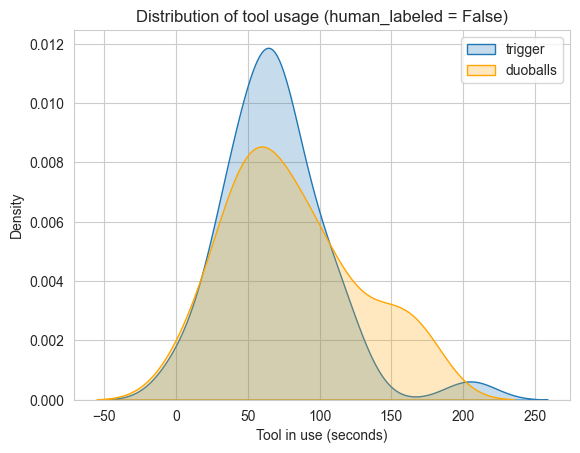

In [93]:
title = 'Distribution of tool usage (human_labeled = False)'

sns.kdeplot(filtered_trigger_df ['tool_time_in_use_sec'], shade=True, label='trigger')
sns.kdeplot(filtered_duoballs_df['tool_time_in_use_sec'], shade=True, color='orange', label='duoballs')


plt.title(title)
plt.xlabel('Tool in use (seconds)')
plt.ylabel('Density')
plt.legend()
plt.savefig(f"diagrams/{title.split('(')[0]}_hl_f.png")

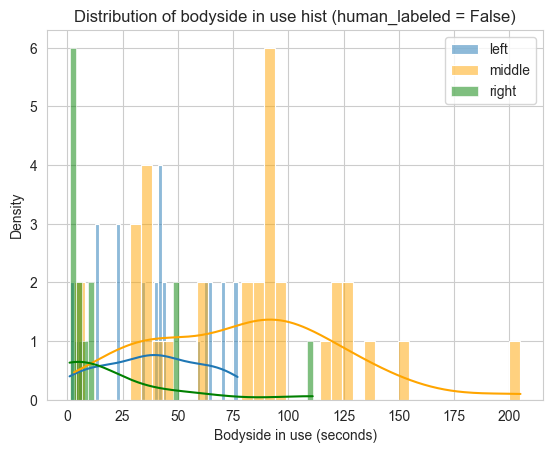

In [94]:
title = 'Distribution of bodyside in use hist (human_labeled = False)'

filtered_left = df[(df['human_labeled'] == False) & (df['bodyside'] == 'left')]
filtered_middle_df = df[(df['human_labeled'] == False) & (df['bodyside'] == 'middle')]
filtered_right_df = df[(df['human_labeled'] == False) & (df['bodyside'] == 'right')]

sns.histplot(filtered_left['bodyside_time_in_use_sec'], bins=40, kde=True, label='left')
sns.histplot(filtered_middle_df['bodyside_time_in_use_sec'], bins=40, kde=True, color='orange', label='middle')
sns.histplot(filtered_right_df['bodyside_time_in_use_sec'], bins=40, kde=True, color='green', label='right')

plt.title(title)
plt.xlabel('Bodyside in use (seconds)')
plt.ylabel('Density')
plt.legend()
plt.savefig(f"diagrams/{title.split('(')[0]}_hl_f.png")

C:\Users\Pirmin.000\AppData\Local\Temp\ipykernel_23428\393818291.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_left['bodyside_time_in_use_sec'], shade=True, label='left')
C:\Users\Pirmin.000\AppData\Local\Temp\ipykernel_23428\393818291.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_middle_df['bodyside_time_in_use_sec'], shade=True, color='orange', label='middle')
C:\Users\Pirmin.000\AppData\Local\Temp\ipykernel_23428\393818291.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_right_df['bodyside_time_in_use_sec'], shade=True, color='green', label='right')


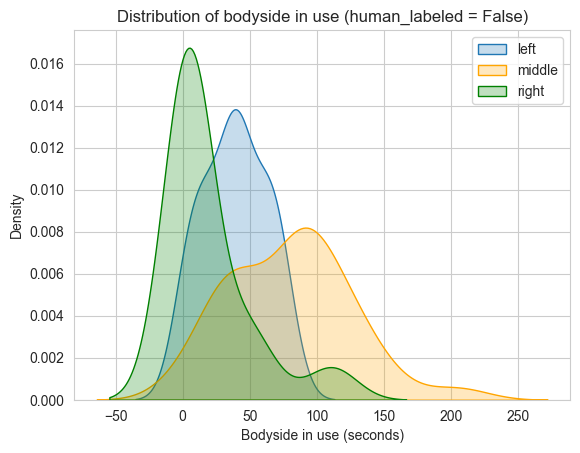

In [95]:
title = 'Distribution of bodyside in use (human_labeled = False)'

filtered_left = df[(df['human_labeled'] == False) & (df['bodyside'] == 'left')]
filtered_middle_df = df[(df['human_labeled'] == False) & (df['bodyside'] == 'middle')]
filtered_right_df = df[(df['human_labeled'] == False) & (df['bodyside'] == 'right')]

sns.kdeplot(filtered_left['bodyside_time_in_use_sec'], shade=True, label='left')
sns.kdeplot(filtered_middle_df['bodyside_time_in_use_sec'], shade=True, color='orange', label='middle')
sns.kdeplot(filtered_right_df['bodyside_time_in_use_sec'], shade=True, color='green', label='right')

plt.title(title)
plt.xlabel('Bodyside in use (seconds)')
plt.ylabel('Density')
plt.legend()
plt.savefig(f"diagrams/{title.split('(')[0]}_hl_f.png")

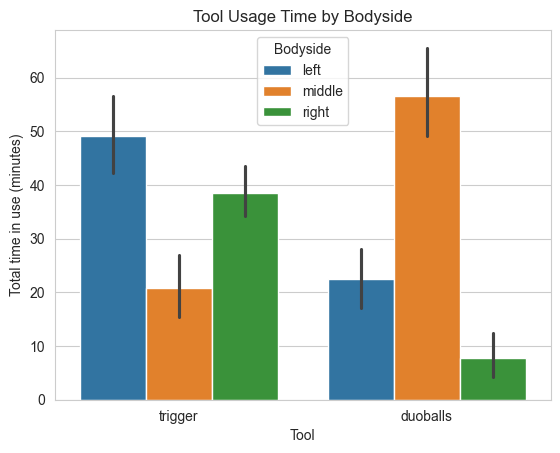

In [96]:
title = 'Tool Usage Time by Bodyside'

tool_time_in_use_minutes_df = df['tool_time_in_use_sec']/60
hue_order = ['left','middle', 'right']

sns.barplot(x='tool', y=tool_time_in_use_minutes_df, hue='bodyside', data=df, estimator=np.sum,hue_order=hue_order)
plt.title(title)
plt.xlabel('Tool')
plt.ylabel('Total time in use (minutes)')
plt.legend(title='Bodyside')
plt.savefig(f"diagrams/{title}.png")

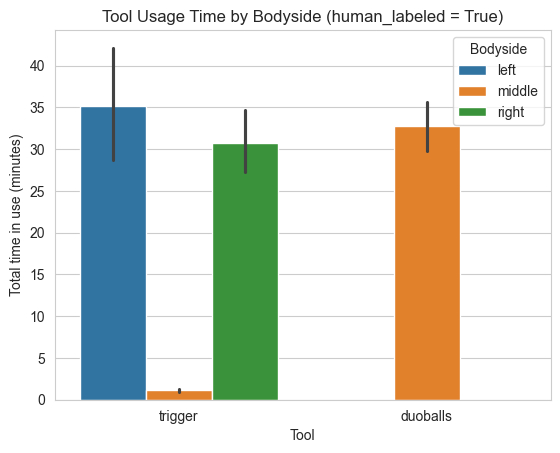

In [97]:
title = 'Tool Usage Time by Bodyside (human_labeled = True)'

tool_time_in_use_minutes_df = df['tool_time_in_use_sec']/60
hue_order = ['left','middle', 'right']
filtered_df = df[(df['human_labeled'] == True)]

sns.barplot(x='tool', y=tool_time_in_use_minutes_df, hue='bodyside', data=filtered_df, estimator=np.sum,hue_order=hue_order)
plt.title(title)
plt.xlabel('Tool')
plt.ylabel('Total time in use (minutes)')
plt.legend(title='Bodyside')
plt.savefig(f"diagrams/{title.split('(')[0]}_hl_t.png")

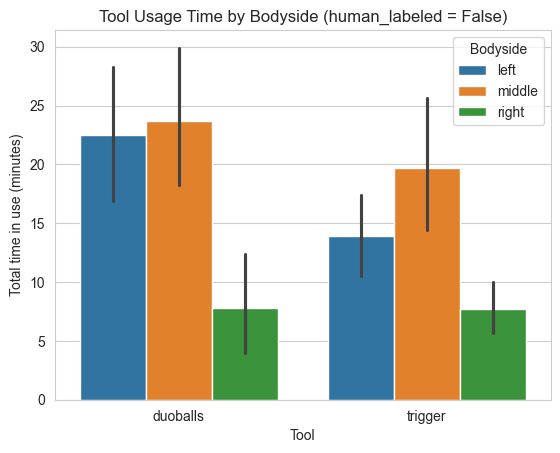

In [98]:
title = 'Tool Usage Time by Bodyside (human_labeled = False)'

tool_time_in_use_minutes_df = df['tool_time_in_use_sec']/60
hue_order = ['left','middle', 'right']
filtered_df = df[(df['human_labeled'] == False)]

sns.barplot(x='tool', y=tool_time_in_use_minutes_df, hue='bodyside', data=filtered_df, estimator=np.sum,hue_order=hue_order)
plt.title(title)
plt.xlabel('Tool')
plt.ylabel('Total time in use (minutes)')
plt.legend(title='Bodyside')
plt.savefig(f"diagrams/{title.split('(')[0]}_hl_f.png")

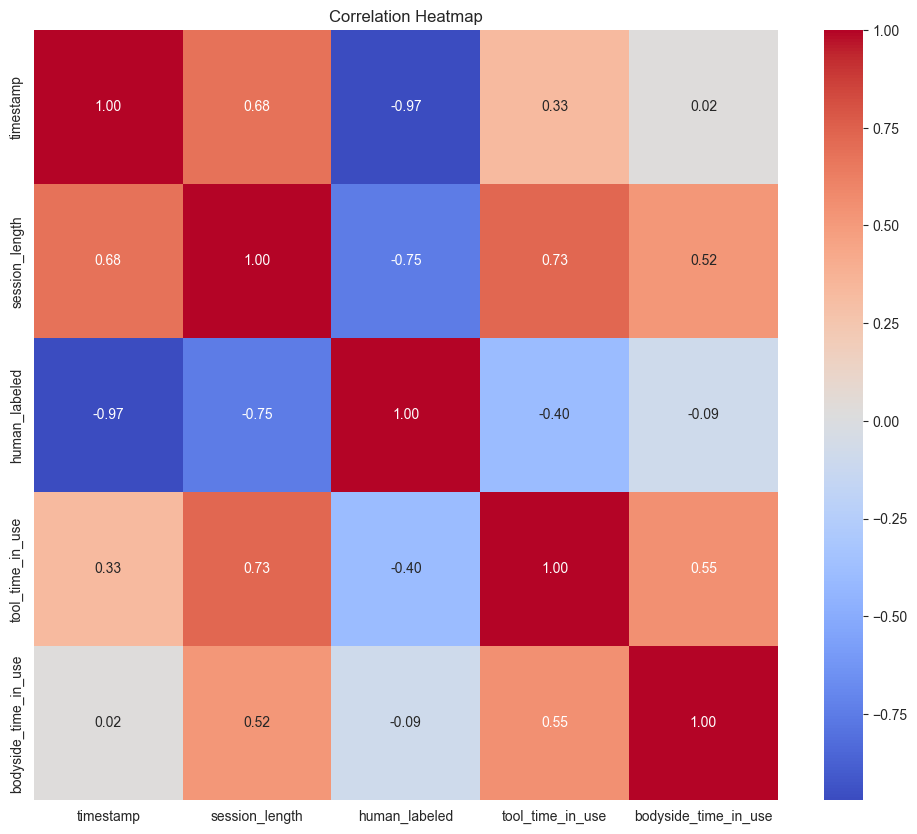

In [99]:
title = 'Correlation Heatmap'
plt.figure(figsize=(12,10))
numeric_data = df.select_dtypes(include=['timedelta64[ns]', 'datetime64[ns]', 'bool'])

correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(title)
plt.savefig(f"diagrams/{title}.png")

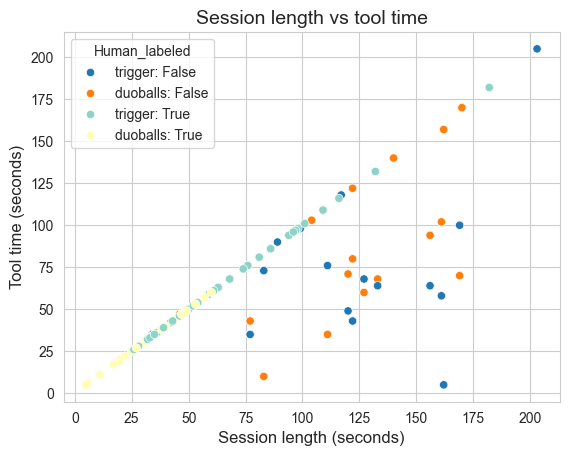

In [100]:
title = 'Session length vs tool time'

plot = sns.scatterplot(x='session_length_sec', y='tool_time_in_use_sec', hue='tool', data=df)

filtered_true_df = df[df['human_labeled'] == True]
sns.scatterplot(x='session_length_sec', y='tool_time_in_use_sec', hue='tool', data=filtered_true_df, palette='Set3', legend='auto')

plot.set_xlabel('Session length (seconds)', fontsize=12)
plot.set_ylabel('Tool time (seconds)', fontsize=12)
plot.set_title(title, fontsize=14)

handles, labels = plot.get_legend_handles_labels()
new_labels = ['trigger: False', 'duoballs: False','trigger: True','duoballs: True']

plot.legend(handles=handles, labels=new_labels, title='Human_labeled')
plt.savefig(f"diagrams/{title}.png")

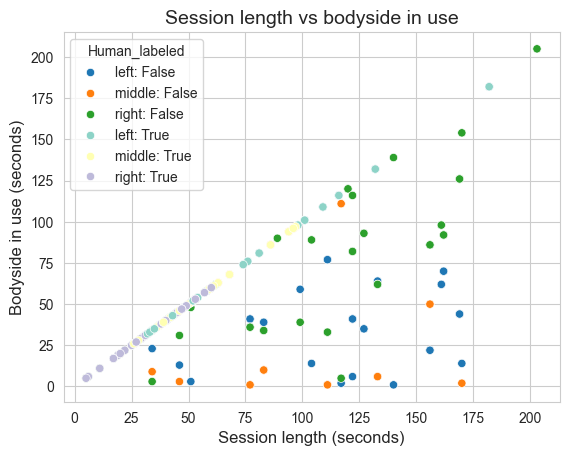

In [101]:
title = 'Session length vs bodyside in use'

plot = sns.scatterplot(x='session_length_sec', y='bodyside_time_in_use_sec', hue='bodyside', data=df)

filtered_true_df = df[df['human_labeled'] == True]
sns.scatterplot(x='session_length_sec', y='bodyside_time_in_use_sec', hue='bodyside', data=filtered_true_df, palette='Set3',
                legend='full')

plot.set_xlabel('Session length (seconds)', fontsize=12)
plot.set_ylabel('Bodyside in use (seconds)', fontsize=12)
plot.set_title(title, fontsize=14)

handles, labels = plot.get_legend_handles_labels()
new_labels = ['left: False', 'middle: False', 'right: False', 'left: True', 'middle: True', 'right: True']

plot.legend(handles=handles, labels=new_labels, title='Human_labeled')
plt.savefig(f"diagrams/{title}.png")

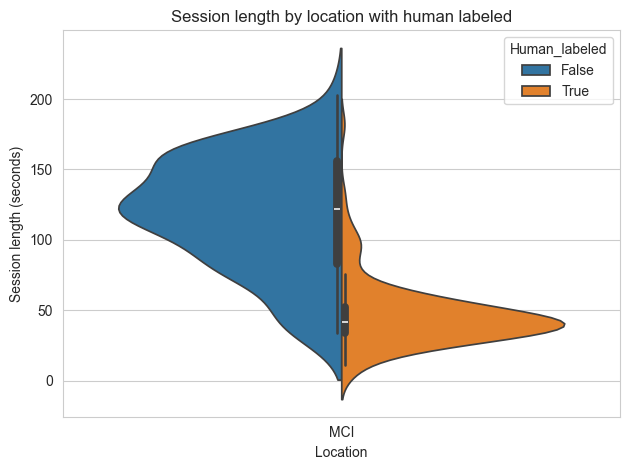

In [102]:
title = 'Session length by location with human labeled'

sns.violinplot(x='location', y='session_length_sec', hue='human_labeled', data=df, split=True)
plt.xlabel('Location')
plt.ylabel('Session length (seconds)')
plt.title(title)
plt.legend(title='Human_labeled')
plt.tight_layout()
plt.savefig(f"diagrams/{title}.png")

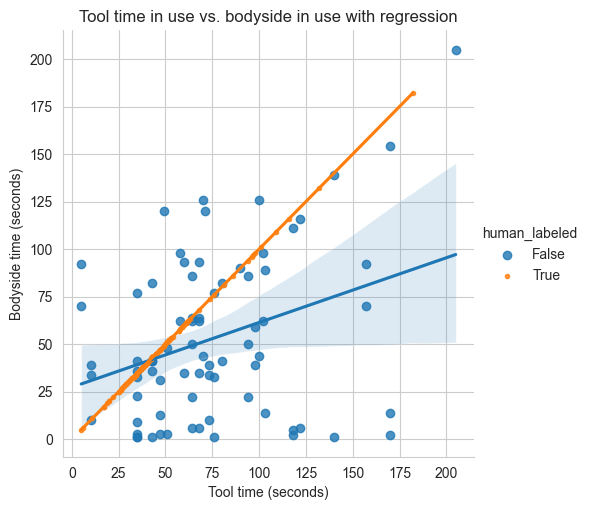

In [103]:
title = 'Tool time in use vs. bodyside in use with regression'

sns.lmplot(x='tool_time_in_use_sec', y='bodyside_time_in_use_sec', data=df, hue='human_labeled', markers=['o', '.'])
plt.xlabel('Tool time (seconds)')
plt.ylabel('Bodyside time (seconds)')
plt.title(title)
plt.savefig(f"diagrams/{title}.png")

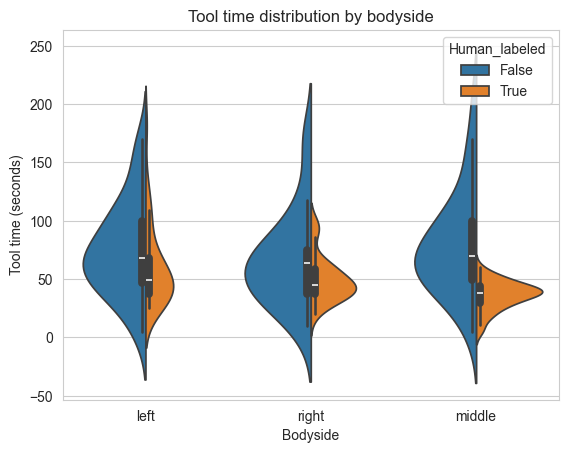

In [104]:
title = 'Tool time distribution by bodyside'

sns.violinplot(x='bodyside', y='tool_time_in_use_sec', data=df, hue='human_labeled', split=True)
plt.xlabel('Bodyside')
plt.ylabel('Tool time (seconds)')
plt.title(title)
plt.legend(title='Human_labeled')
plt.savefig(f"diagrams/{title}.png")

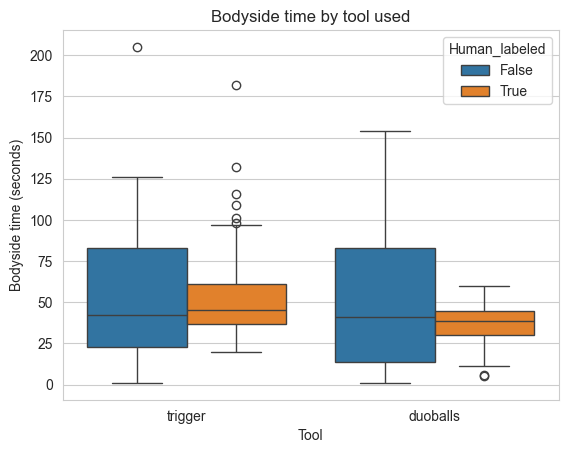

In [105]:
title = 'Bodyside time by tool used'

sns.boxplot(x='tool', y='bodyside_time_in_use_sec', data=df, hue='human_labeled')
plt.xlabel('Tool')
plt.ylabel('Bodyside time (seconds)')
plt.title(title)
plt.legend(title='Human_labeled')
plt.savefig(f"diagrams/{title}.png")

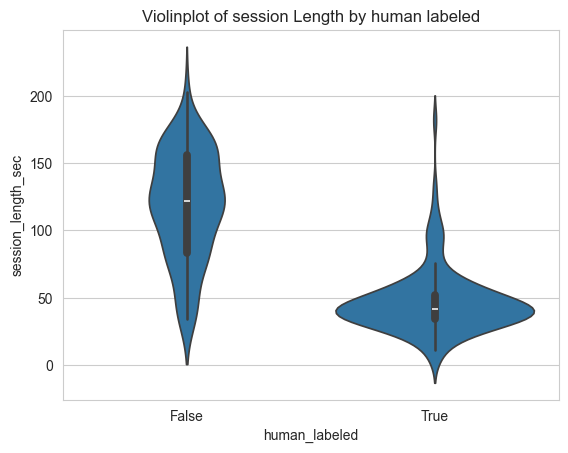

In [106]:
title = 'Violinplot of session Length by human labeled'

sns.violinplot(x='human_labeled', y='session_length_sec', data=df)
plt.title(title)
plt.savefig(f"diagrams/{title}.png")

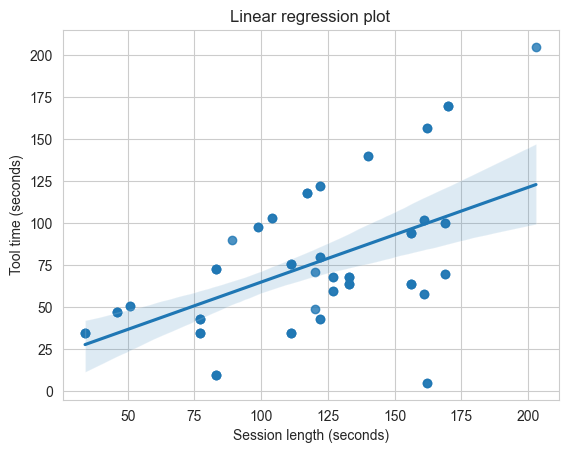

In [107]:
title = 'Linear regression plot'

filtered_trigger_df = df[(df['human_labeled'] == False) & (df['tool'] == 'trigger')]
filtered_buoballs_df = df[(df['human_labeled'] == False) & (df['tool'] == 'buoballs')]
sns.regplot(x='session_length_sec', y='tool_time_in_use_sec', data=filtered_df)
plt.title(title)
plt.xlabel('Session length (seconds)')
plt.ylabel('Tool time (seconds)')
plt.savefig(f"diagrams/{title}.png")

'diagrams/Linear regression plot _hl_f.png'

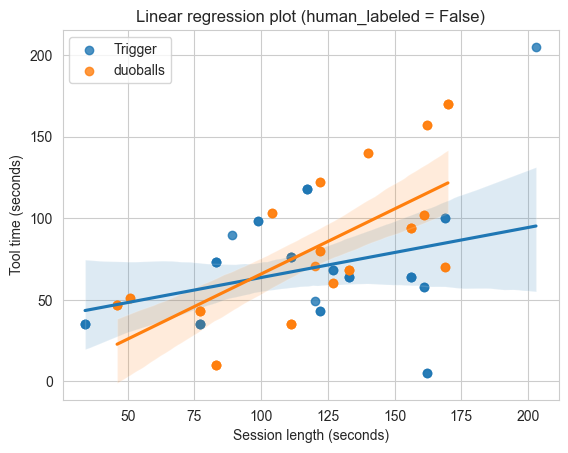

In [108]:
title = 'Linear regression plot (human_labeled = False)'

filtered_trigger_df = df[(df['human_labeled'] == False) & (df['tool'] == 'trigger')]
filtered_buoballs_df = df[(df['human_labeled'] == False) & (df['tool'] == 'duoballs')]

# Create separate regression plots for 'trigger' and 'buoballs'
sns.regplot(x='session_length_sec', y='tool_time_in_use_sec', data=filtered_trigger_df, label='Trigger')
sns.regplot(x='session_length_sec', y='tool_time_in_use_sec', data=filtered_buoballs_df, label='duoballs')

plt.title(title)
plt.xlabel('Session length (seconds)')
plt.ylabel('Tool time (seconds)')
plt.legend()
f"diagrams/{title.split('(')[0]}_hl_f.png"

'diagrams/Linear regression plot _hl_f.png'

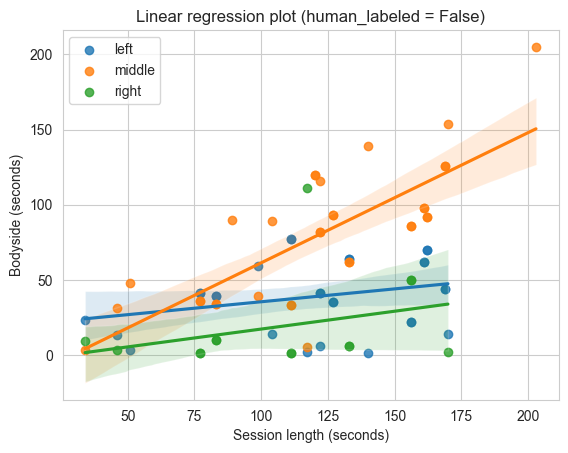

In [109]:
title = 'Linear regression plot (human_labeled = False)'

filtered_left_df = df[(df['human_labeled'] == False) & (df['bodyside'] == 'left')]
filtered_middle_df = df[(df['human_labeled'] == False) & (df['bodyside'] == 'middle')]
filtered_right_df = df[(df['human_labeled'] == False) & (df['bodyside'] == 'right')]

sns.regplot(x='session_length_sec', y='bodyside_time_in_use_sec', data=filtered_left_df, label='left')
sns.regplot(x='session_length_sec', y='bodyside_time_in_use_sec', data=filtered_middle_df, label='middle')
sns.regplot(x='session_length_sec', y='bodyside_time_in_use_sec', data=filtered_right_df, label='right')

plt.title(title)
plt.xlabel('Session length (seconds)')
plt.ylabel('Bodyside (seconds)')
plt.legend()
f"diagrams/{title.split('(')[0]}_hl_f.png"